# SkilioMall Churn Prediction - Training Pipeline

This notebook implements a complete machine learning pipeline for customer churn prediction. The workflow includes data loading, preprocessing, feature engineering, model training, evaluation, and interpretability analysis.

Pipeline Overview:
1. Configuration and module setup
2. Data loading and splitting
3. Feature engineering
4. Preprocessing and transformation
5. Baseline model training
6. Hyperparameter tuning
7. Threshold optimization
8. Final model training
9. Evaluation on test set
10. Model visualization and interpretation
11. Artifact storage

## 1. Setup and Configuration

Load configuration file, set up project paths, and import required libraries. This cell also establishes fallback mechanisms for custom modules.

In [72]:
# Import required libraries
import os
import sys
import yaml
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (roc_auc_score, average_precision_score,
                             precision_recall_curve, precision_score,
                             recall_score, f1_score, confusion_matrix)
import shap
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")
sns.set_style("whitegrid")

# Set up project root directory and add src to path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, os.path.join(project_root, 'src'))
print(f"Project root: {project_root}")

# Load configuration from YAML file
config_path = os.path.join(project_root, 'config.yaml')
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

# Extract key configuration parameters
RANDOM_STATE = config['GENERAL'].get('RANDOM_STATE', 42)
TARGET_COL = config['GENERAL'].get('TARGET_COLUMN', 'churn_label')
ID_COL = config['GENERAL'].get('ID_COLUMN', None)
OUTPUTS_DIR = os.path.join(project_root, config['PATHS'].get('OUTPUTS_DIR', 'outputs'))

# Create outputs directory if it doesn't exist
os.makedirs(OUTPUTS_DIR, exist_ok=True)

print("Config loaded. Random state:", RANDOM_STATE)
print("Target column:", TARGET_COL)
print("Outputs dir:", OUTPUTS_DIR)

Project root: c:\Users\ngthtnhung\Documents\code tự học\TechSpire\skilio_mall_churn_prediction
Config loaded. Random state: 42
Target column: churn_label
Outputs dir: c:\Users\ngthtnhung\Documents\code tự học\TechSpire\skilio_mall_churn_prediction\outputs/


## 2. Module Imports with Fallback Mechanisms

Import custom modules from the src directory. If modules are not available, implement fallback functions to ensure the notebook can still run independently.

In [73]:
try:
    from data_loader import load_config, load_raw_data
except Exception as e:
    print("Warning: data_loader.load_config or load_raw_data not found. Using simple loader fallback.")
    def load_raw_data(config_path):
        # fallback: read path from config yaml we already loaded
        raw_rel = config['PATHS']['RAW_DATA']
        data_path = os.path.join(project_root, raw_rel)
        if not os.path.exists(data_path):
            raise FileNotFoundError(f"Raw data not found: {data_path}")
        df = pd.read_csv(data_path, index_col=ID_COL)
        return df

try:
    from features import create_all_features as create_features
except Exception as e:
    print("Warning: features.create_all_features not found. Using identity fallback.")
    def create_features(df):
        # fallback: return copy (no new features)
        return df.copy()

try:
    from preprocessing import build_preprocessor
except Exception as e:
    print("Warning: preprocessing.build_preprocessor not found. Using simple numeric/categorical pipeline fallback.")
    from sklearn.compose import ColumnTransformer
    from sklearn.pipeline import Pipeline
    from sklearn.preprocessing import StandardScaler, OneHotEncoder
    from sklearn.impute import SimpleImputer

    def build_preprocessor(numerical_features=None, categorical_features=None):
        # if None, determine later from training set
        num_pipe = Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ])
        cat_pipe = Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ])
        # we return a factory that we'll call with feature lists after FE
        def factory(num_feats, cat_feats):
            return ColumnTransformer([
                ('num', num_pipe, num_feats),
                ('cat', cat_pipe, cat_feats),
            ], sparse_threshold=0)
        return factory

try:
    from modeling import train_baseline_models, tune_model_optuna, fit_final_model
except Exception as e:
    print("Warning: modeling module functions missing. Using simple implementations.")
    from sklearn.linear_model import LogisticRegression
    from sklearn.ensemble import RandomForestClassifier
    import lightgbm as lgb
    import xgboost as xgb

    def train_baseline_models(X_train, y_train, X_val, y_val, random_state=RANDOM_STATE):
        results = {}

        # Logistic Regression
        lr = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=random_state)
        lr.fit(X_train, y_train)
        preds = lr.predict_proba(X_val)[:,1]
        results['LogisticRegression'] = {'model': lr, 'val_proba': preds}

        # Random Forest
        rf = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=random_state)
        rf.fit(X_train, y_train)
        preds = rf.predict_proba(X_val)[:,1]
        results['RandomForest'] = {'model': rf, 'val_proba': preds}

        # XGBoost
        scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
        xgb_model = xgb.XGBClassifier(
            n_estimators=500,
            scale_pos_weight=scale_pos_weight,
            random_state=random_state,
            eval_metric='logloss'
        )
        xgb_model.fit(X_train, y_train)
        preds = xgb_model.predict_proba(X_val)[:,1]
        results['XGBoost'] = {'model': xgb_model, 'val_proba': preds}

        # LightGBM
        lgbm = lgb.LGBMClassifier(n_estimators=500, class_weight='balanced', random_state=random_state)
        lgbm.fit(X_train, y_train)
        preds = lgbm.predict_proba(X_val)[:,1]
        results['LightGBM'] = {'model': lgbm, 'val_proba': preds}

        return results

    def tune_model_optuna(X_train, y_train, X_val, y_val, time_budget_s=600, random_state=RANDOM_STATE):
        # Simple placeholder: return LightGBM trained on train+val without real tuning
        import lightgbm as lgb
        model = lgb.LGBMClassifier(n_estimators=1000, learning_rate=0.03, class_weight='balanced', random_state=random_state)
        model.fit(X_train, y_train)
        return model, {'n_estimators':1000, 'learning_rate':0.03}

    def fit_final_model(X_train, y_train, params=None, random_state=RANDOM_STATE):
        import lightgbm as lgb
        params = params or {}
        model = lgb.LGBMClassifier(random_state=random_state, **params)
        model.fit(X_train, y_train)
        return model

try:
    from evaluation import (compute_threshold_metrics, plot_lift_gain, plot_calibration_curve,
                            plot_confusion_matrix, compute_lift_at_k)
except Exception as e:
    print("Warning: evaluation helpers missing. Using simple local implementations.")
    def compute_threshold_metrics(y_true, y_proba, threshold=0.5):
        y_pred = (y_proba >= threshold).astype(int)
        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        cm = confusion_matrix(y_true, y_pred)
        return {'precision': precision, 'recall': recall, 'f1': f1, 'confusion_matrix': cm}

    def compute_lift_at_k(y_true, y_proba, k=0.2):
        # returns recall@topk and lift@topk
        df_tmp = pd.DataFrame({'y': y_true, 'p': y_proba})
        df_tmp = df_tmp.sort_values('p', ascending=False).reset_index(drop=True)
        top_n = int(len(df_tmp) * k)
        top = df_tmp.iloc[:top_n]
        recall_at_k = top['y'].sum() / df_tmp['y'].sum() if df_tmp['y'].sum() > 0 else 0
        lift = (top['y'].mean() / df_tmp['y'].mean()) if df_tmp['y'].mean() > 0 else np.nan
        return {'recall_at_k': recall_at_k, 'lift_at_k': lift}

    def plot_lift_gain(y_true, y_proba, k=0.2):
        out = compute_lift_at_k(y_true, y_proba, k)
        print(f"Recall@Top{k*100:.0f}% = {out['recall_at_k']:.3f}; Lift@Top{k*100:.0f}% = {out['lift_at_k']:.3f}")


## 3. Load Raw Data

Load the raw dataset from CSV file. Perform basic validation to ensure the target column exists.

In [74]:
# Get data path from configuration
raw_rel = config['PATHS']['RAW_DATA']
data_path = os.path.join(project_root, raw_rel)

# Validate file existence
if not os.path.exists(data_path):
    raise FileNotFoundError(f"Raw data file not found: {data_path}")

# Load data using custom loader if available, otherwise use pandas
df = load_raw_data(config_path) if 'load_raw_data' in globals() else pd.read_csv(data_path, index_col=ID_COL)

print("Raw data shape:", df.shape)

# Validate that target column exists in the dataset
if TARGET_COL not in df.columns:
    raise KeyError(f"Target column '{TARGET_COL}' not found in data. Columns: {df.columns.tolist()}")


2025-11-17 15:50:24,507 - data_loader - INFO - Config loaded from: c:\Users\ngthtnhung\Documents\code tự học\TechSpire\skilio_mall_churn_prediction\config.yaml
2025-11-17 15:50:24,507 - data_loader - INFO - Starting to load data from: c:\Users\ngthtnhung\Documents\code tự học\TechSpire\skilio_mall_churn_prediction\data/skiliomall_data.csv
2025-11-17 15:50:24,507 - data_loader - INFO - Starting to load data from: c:\Users\ngthtnhung\Documents\code tự học\TechSpire\skilio_mall_churn_prediction\data/skiliomall_data.csv
2025-11-17 15:50:24,665 - data_loader - INFO - Data loaded: 50000 rows, 32 columns
2025-11-17 15:50:24,690 - data_loader - INFO - Memory usage: 15.79 MB
2025-11-17 15:50:24,665 - data_loader - INFO - Data loaded: 50000 rows, 32 columns
2025-11-17 15:50:24,690 - data_loader - INFO - Memory usage: 15.79 MB
2025-11-17 15:50:24,690 - data_loader - INFO - Columns: age, country, city, reg_days, marketing_source... (32 total)
2025-11-17 15:50:24,690 - data_loader - INFO - Index na

Raw data shape: (50000, 32)


## 4. Train/Validation/Test Split

Split the dataset into three sets using stratified sampling to maintain class distribution:
- Training set: for model training
- Validation set: for hyperparameter tuning and threshold selection
- Test set: for final unbiased evaluation

The split is performed in two steps to ensure correct proportions.

In [75]:
# Get split ratios from configuration
train_ratio = config['DATA_SPLIT']['TRAIN_RATIO']
val_ratio = config['DATA_SPLIT']['VAL_RATIO']
test_ratio = config['DATA_SPLIT']['TEST_RATIO']

# Ensure ratios sum to 1.0
assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6, "Train/Val/Test ratios must sum to 1"

# Step 1: Split into training and temporary set (validation + test)
temp_size = val_ratio + test_ratio
train_df, temp_df = train_test_split(df, test_size=temp_size, stratify=df[TARGET_COL], random_state=RANDOM_STATE)

# Step 2: Split temporary set into validation and test sets proportionally
val_df, test_df = train_test_split(temp_df, test_size=(test_ratio/temp_size), stratify=temp_df[TARGET_COL], random_state=RANDOM_STATE)

# Display split sizes and class distributions
print("Split sizes:", train_df.shape, val_df.shape, test_df.shape)
print("Train/Val/Test churn distribution:")
print(train_df[TARGET_COL].value_counts(normalize=True))
print(val_df[TARGET_COL].value_counts(normalize=True))
print(test_df[TARGET_COL].value_counts(normalize=True))

# Save checkpoint of splits for reproducibility
checkpoint_path = os.path.join(project_root, config['PATHS'].get('CHECKPOINT_DATA', 'data/processed_data_split.pkl'))
os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)
pd.to_pickle({'train': train_df, 'val': val_df, 'test': test_df}, checkpoint_path)
print("Saved data split checkpoint:", checkpoint_path)


Split sizes: (35000, 32) (7500, 32) (7500, 32)
Train/Val/Test churn distribution:
churn_label
0    0.75
1    0.25
Name: proportion, dtype: float64
churn_label
0    0.75
1    0.25
Name: proportion, dtype: float64
churn_label
0    0.75
1    0.25
Name: proportion, dtype: float64
Saved data split checkpoint: c:\Users\ngthtnhung\Documents\code tự học\TechSpire\skilio_mall_churn_prediction\data/processed_data_split.pkl


## 5. Feature Engineering

Apply feature engineering transformations to create new predictive features. The same transformations are applied consistently to train, validation, and test sets.

In [76]:
print("Applying feature engineering (create_features)...")
# If create_features expects (X, y) or DataFrame, we try both
def apply_create_features(df_in):
    try:
        out = create_features(df_in)
        return out
    except Exception:
        try:
            # if signature create_features(X, y)
            X = df_in.drop(columns=[TARGET_COL])
            y = df_in[TARGET_COL]
            X_new = create_features(X, y)
            # attach target back
            X_new[TARGET_COL] = y.values
            return X_new
        except Exception as e:
            print("Feature function failed:", e)
            return df_in.copy()

train_fe = apply_create_features(train_df)
val_fe = apply_create_features(val_df)
test_fe = apply_create_features(test_df)

print("After FE shapes:", train_fe.shape, val_fe.shape, test_fe.shape)

# Separate X/y after FE
X_train = train_fe.drop(columns=[TARGET_COL])
y_train = train_fe[TARGET_COL].astype(int)

X_val = val_fe.drop(columns=[TARGET_COL])
y_val = val_fe[TARGET_COL].astype(int)

X_test = test_fe.drop(columns=[TARGET_COL])
y_test = test_fe[TARGET_COL].astype(int)

# Identify numerical/categorical features (fallback to config if available)
num_feats = config['FEATURE_ENGINEERING'].get('NUMERICAL_FEATURES', [])
cat_feats = config['FEATURE_ENGINEERING'].get('CATEGORICAL_FEATURES', [])

# If lists are empty, infer from X_train dtypes
if not num_feats and not cat_feats:
    num_feats = X_train.select_dtypes(include=[np.number]).columns.tolist()
    cat_feats = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"Numerical features: {len(num_feats)}; Categorical features: {len(cat_feats)}")


2025-11-17 15:50:24,815 - features - INFO - Starting feature engineering pipeline...
2025-11-17 15:50:24,820 - features - INFO - Creating tenure features...
2025-11-17 15:50:24,824 - features - INFO - Tenure features created successfully
2025-11-17 15:50:24,820 - features - INFO - Creating tenure features...
2025-11-17 15:50:24,824 - features - INFO - Tenure features created successfully
2025-11-17 15:50:24,827 - features - INFO - Creating intensity ratio features...
2025-11-17 15:50:24,832 - features - INFO - Intensity ratio features created successfully
2025-11-17 15:50:24,833 - features - INFO - Creating interaction features...
2025-11-17 15:50:24,833 - features - INFO - Interaction features created successfully
2025-11-17 15:50:24,827 - features - INFO - Creating intensity ratio features...
2025-11-17 15:50:24,832 - features - INFO - Intensity ratio features created successfully
2025-11-17 15:50:24,833 - features - INFO - Creating interaction features...
2025-11-17 15:50:24,833 - f

Applying feature engineering (create_features)...


2025-11-17 15:50:24,893 - features - INFO - Creating interaction features...
2025-11-17 15:50:24,893 - features - INFO - Interaction features created successfully
2025-11-17 15:50:24,904 - features - INFO - Feature engineering completed
2025-11-17 15:50:24,907 - features - INFO - Input shape: (7500, 32), Output shape: (7500, 38)
2025-11-17 15:50:24,907 - features - INFO - Total NaN values in output: 0
2025-11-17 15:50:24,893 - features - INFO - Interaction features created successfully
2025-11-17 15:50:24,904 - features - INFO - Feature engineering completed
2025-11-17 15:50:24,907 - features - INFO - Input shape: (7500, 32), Output shape: (7500, 38)
2025-11-17 15:50:24,907 - features - INFO - Total NaN values in output: 0


After FE shapes: (35000, 38) (7500, 38) (7500, 38)
Numerical features: 27; Categorical features: 4


## 6. Data Preprocessing

Build and fit preprocessing pipeline on training data only to avoid data leakage. The pipeline handles:
- Numerical features: imputation and standardization
- Categorical features: imputation and one-hot encoding

The fitted preprocessor is then applied to validation and test sets.

In [77]:
print("Building preprocessor and fitting on train only...")
preprocessor_factory = build_preprocessor()
# If build_preprocessor returned a factory (our fallback), call it; otherwise it's a fitted transformer
if callable(preprocessor_factory):
    preprocessor = preprocessor_factory(num_feats, cat_feats)
else:
    preprocessor = preprocessor_factory  # assume it's a transformer class

# Fit preprocessor on X_train only
preprocessor = preprocessor.fit(X_train)
X_train_prep = preprocessor.transform(X_train)
X_val_prep = preprocessor.transform(X_val)
X_test_prep = preprocessor.transform(X_test)

# If transformer returns numpy arrays, convert to DataFrame for SHAP and interpretability (keep column names)
def get_feature_names_from_preprocessor(preproc, num_feats, cat_feats):
    # best-effort extraction
    try:
        # If it's ColumnTransformer with named transformers
        if hasattr(preproc, 'transformers_'):
            feature_names = []
            for name, trans, cols in preproc.transformers_:
                if name == 'num':
                    feature_names.extend(cols)
                elif name == 'cat':
                    # try to get onehot feature names
                    ohe = trans.named_steps.get('ohe') or trans.named_steps.get('onehot')
                    if ohe is not None:
                        names = ohe.get_feature_names_out(cols)
                        feature_names.extend(list(names))
                    else:
                        feature_names.extend(cols)
            return feature_names
    except Exception:
        pass
    # fallback
    return list(num_feats) + list(cat_feats)

feature_names = get_feature_names_from_preprocessor(preprocessor, num_feats, cat_feats)
print("Prepared feature names length:", len(feature_names))

# Convert prepared arrays to DataFrames if necessary
if isinstance(X_train_prep, np.ndarray):
    X_train_prep_df = pd.DataFrame(X_train_prep, columns=feature_names, index=X_train.index)
    X_val_prep_df = pd.DataFrame(X_val_prep, columns=feature_names, index=X_val.index)
    X_test_prep_df = pd.DataFrame(X_test_prep, columns=feature_names, index=X_test.index)
else:
    X_train_prep_df = X_train_prep
    X_val_prep_df = X_val_prep
    X_test_prep_df = X_test_prep


Building preprocessor and fitting on train only...
Prepared feature names length: 55
Prepared feature names length: 55


## 7. Baseline Model Training

Train multiple baseline models to compare performance:
- Logistic Regression
- Random Forest
- XGBoost
- LightGBM

Evaluate each model on the validation set using ROC-AUC and PR-AUC metrics. Select the best performing model for further tuning.

In [78]:
print("Training baseline models (Logistic, RandomForest, XGBoost, LightGBM)...")
baseline_results = train_baseline_models(X_train_prep_df.values, y_train.values, X_val_prep_df.values, y_val.values, random_state=RANDOM_STATE)
# baseline_results is expected dict: name -> {'model': model, 'val_proba': preds}
print("Baseline models trained:", list(baseline_results.keys()))

# Evaluate baselines on validation
def evaluate_probas(y_true, y_proba):
    roc = roc_auc_score(y_true, y_proba)
    pr = average_precision_score(y_true, y_proba)
    return {'roc_auc': roc, 'pr_auc': pr}

baseline_metrics = {}
for name, info in baseline_results.items():
    proba = info.get('val_proba') if isinstance(info, dict) else None
    model = info.get('model') if isinstance(info, dict) else info
    if proba is None:
        proba = model.predict_proba(X_val_prep_df.values)[:,1]
    baseline_metrics[name] = evaluate_probas(y_val.values, proba)
print("Baseline validation metrics (ROC-AUC, PR-AUC):")
for k,v in baseline_metrics.items():
    print(k, v)

# Choose best model by ROC-AUC or PR-AUC
best_name = max(baseline_metrics.items(), key=lambda x: (x[1]['roc_auc'], x[1]['pr_auc']))[0]
print("Selected best baseline:", best_name)

best_model = baseline_results[best_name]['model']


Training baseline models (Logistic, RandomForest, XGBoost, LightGBM)...
[LightGBM] [Info] Number of positive: 8750, number of negative: 26250
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002100 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3615
[LightGBM] [Info] Number of data points in the train set: 35000, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 8750, number of negative: 26250
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002100 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3615
[LightGBM] [Info] Number of data points in the train set: 35000, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000

## 8. Hyperparameter Tuning

Perform hyperparameter optimization using Optuna or fallback to default parameters. This step aims to improve model performance beyond the baseline configuration.

In [79]:
do_tune = True
if do_tune:
    print("Tuning best model lightly (Optuna or fallback)...")
    try:
        tuned_model, best_params = tune_model_optuna(X_train_prep_df.values, y_train.values, X_val_prep_df.values, y_val.values, time_budget_s=900, random_state=RANDOM_STATE)
        final_model = tuned_model
        print("Tuning complete. Best params:", best_params)
    except Exception as e:
        print("Tuning failed or not implemented in modeling. Using selected baseline model.")
        final_model = best_model
else:
    final_model = best_model

Tuning best model lightly (Optuna or fallback)...
[LightGBM] [Info] Number of positive: 8750, number of negative: 26250
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002497 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3615
[LightGBM] [Info] Number of data points in the train set: 35000, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Tuning complete. Best params: {'n_estimators': 1000, 'learning_rate': 0.03}
Tuning complete. Best params: {'n_estimators': 1000, 'learning_rate': 0.03}


## 9. Optimal Threshold Selection

Select the optimal classification threshold on the validation set by maximizing the F1 score. This threshold will be used for final predictions on the test set.

Note: This is done BEFORE retraining to prevent data leakage.

In [80]:
print("Selecting optimal threshold on validation set...")
val_proba_before_retrain = final_model.predict_proba(X_val_prep_df.values)[:,1]
precisions, recalls, thresholds = precision_recall_curve(y_val.values, val_proba_before_retrain)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-12)
best_idx = np.nanargmax(f1_scores)
# Fix: ensure best_idx doesn't exceed thresholds length
best_idx = min(best_idx, len(thresholds) - 1)
best_threshold = thresholds[best_idx] if len(thresholds) > 0 else 0.5
print(f"Chosen operating threshold (best F1 on val): {best_threshold:.4f}")


Selecting optimal threshold on validation set...
Chosen operating threshold (best F1 on val): 0.5397


## 10. Final Model Retraining

Retrain the final model on combined training and validation data to maximize the use of available data for production deployment.

In [81]:
retrain_on_full = True
if retrain_on_full:
    print("Retraining final model on train+val...")
    X_full = pd.concat([X_train_prep_df, X_val_prep_df], axis=0)
    y_full = pd.concat([y_train, y_val], axis=0)
    try:
        final_model = fit_final_model(X_full.values, y_full.values, params=None, random_state=RANDOM_STATE)
        print("Retrain finished.")
    except Exception:
        try:
            final_model.fit(X_full.values, y_full.values)
            print("Retrain finished (sklearn fit).")
        except Exception as e:
            print("Retrain failed:", e)


Retraining final model on train+val...
[LightGBM] [Info] Number of positive: 10625, number of negative: 31875
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003068 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3621
[LightGBM] [Info] Number of data points in the train set: 42500, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.250000 -> initscore=-1.098612
[LightGBM] [Info] Start training from score -1.098612
Retrain finished.
Retrain finished.


## 11. Test Set Evaluation

Evaluate the final model on the held-out test set to get an unbiased estimate of model performance. Calculate multiple metrics including:
- ROC-AUC and PR-AUC
- Precision, Recall, and F1 score at optimal threshold
- Confusion matrix
- Lift at top 20 percent

Save the evaluation summary to a YAML file for documentation.

In [82]:
print("Evaluating final model on hold-out TEST set...")
y_test_proba = final_model.predict_proba(X_test_prep_df.values)[:,1]
roc_test = roc_auc_score(y_test.values, y_test_proba)
pr_test = average_precision_score(y_test.values, y_test_proba)
print(f"TEST ROC-AUC: {roc_test:.4f}")
print(f"TEST PR-AUC:  {pr_test:.4f}")

# Compute threshold metrics on test using the pre-selected threshold
test_metrics = compute_threshold_metrics(y_test.values, y_test_proba, threshold=best_threshold)
print("Test metrics at chosen threshold:")
print(test_metrics)
print("Confusion matrix:")
print(test_metrics['confusion_matrix'])

# Compute Lift & Gain metrics (Top-K)
top_k = config['EVALUATION'].get('LIFT_GAIN_TOP_K', 0.2)
lift_results = compute_lift_at_k(y_test.values, y_test_proba, k=top_k)
print(f"Lift/Gain @ Top {top_k*100:.0f}%:", lift_results)

# Save evaluation summary (convert all numpy types to Python native types)
eval_summary = {
    'test': {
        'roc_auc': float(roc_test),
        'pr_auc': float(pr_test),
        'threshold': float(best_threshold),
        'precision': float(test_metrics['precision']),
        'recall': float(test_metrics['recall']),
        'f1': float(test_metrics['f1']),
        'confusion_matrix': test_metrics['confusion_matrix'].tolist(),
        'lift_at_top_k': {
            'recall_at_k': float(lift_results['recall_at_k']),
            'lift_at_k': float(lift_results['lift_at_k']) if not np.isnan(lift_results['lift_at_k']) else None
        }
    }
}
with open(os.path.join(OUTPUTS_DIR, 'evaluation_summary.yaml'), 'w') as f:
    yaml.safe_dump(eval_summary, f)
print("Saved evaluation summary to outputs.")


Evaluating final model on hold-out TEST set...
TEST ROC-AUC: 0.9841
TEST PR-AUC:  0.9562
Test metrics at chosen threshold:
{'precision': 0.8976953344575604, 'recall': 0.8517333333333333, 'f1': 0.8741105637657361, 'confusion_matrix': array([[5443,  182],
       [ 278, 1597]], dtype=int64)}
Confusion matrix:
[[5443  182]
 [ 278 1597]]
Lift/Gain @ Top 20%: {'recall_at_k': 0.7552, 'lift_at_k': 3.776}
Saved evaluation summary to outputs.


## 12. Model Performance Visualizations

Generate comprehensive visualizations to understand model behavior and performance across different metrics and perspectives.

### 12.1 Baseline Model Comparison

Compare ROC-AUC and PR-AUC scores across all baseline models on the validation set. The best performing model is highlighted in green.

Creating baseline models comparison chart...


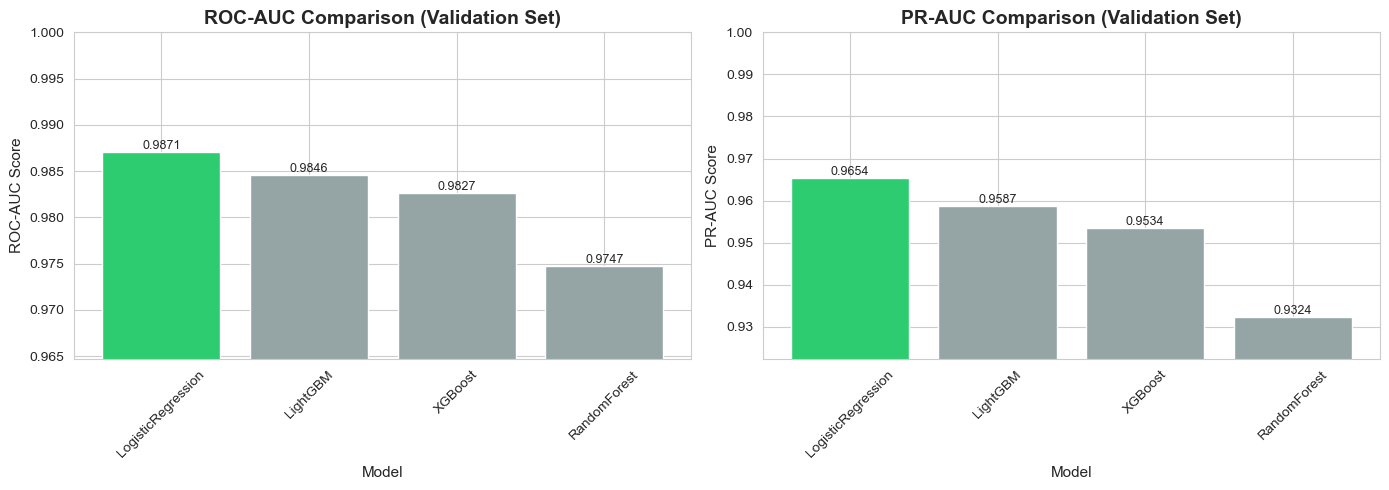

Saved: c:\Users\ngthtnhung\Documents\code tự học\TechSpire\skilio_mall_churn_prediction\outputs/baseline_models_comparison.png


In [83]:
from sklearn.metrics import roc_curve, auc

# 1. Baseline models comparison
print("Creating baseline models comparison chart...")
df_baseline = pd.DataFrame([
    {'Model': name, 'ROC-AUC': metrics['roc_auc'], 'PR-AUC': metrics['pr_auc']}
    for name, metrics in baseline_metrics.items()
]).sort_values(by='ROC-AUC', ascending=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# ROC-AUC comparison
colors = ['#2ecc71' if model == best_name else '#95a5a6' for model in df_baseline['Model']]
bars1 = ax1.bar(df_baseline['Model'], df_baseline['ROC-AUC'], color=colors)
ax1.set_title('ROC-AUC Comparison (Validation Set)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Model', fontsize=11)
ax1.set_ylabel('ROC-AUC Score', fontsize=11)
ax1.set_ylim(df_baseline['ROC-AUC'].min() - 0.01, 1.0)
ax1.tick_params(axis='x', rotation=45)
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}', ha='center', va='bottom', fontsize=9)

# PR-AUC comparison
bars2 = ax2.bar(df_baseline['Model'], df_baseline['PR-AUC'], color=colors)
ax2.set_title('PR-AUC Comparison (Validation Set)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Model', fontsize=11)
ax2.set_ylabel('PR-AUC Score', fontsize=11)
ax2.set_ylim(df_baseline['PR-AUC'].min() - 0.01, 1.0)
ax2.tick_params(axis='x', rotation=45)
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUTS_DIR, 'baseline_models_comparison.png'), dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved: {os.path.join(OUTPUTS_DIR, 'baseline_models_comparison.png')}")

### 12.2 ROC Curve

Receiver Operating Characteristic curve shows the trade-off between true positive rate and false positive rate across all classification thresholds.

Creating ROC curve...


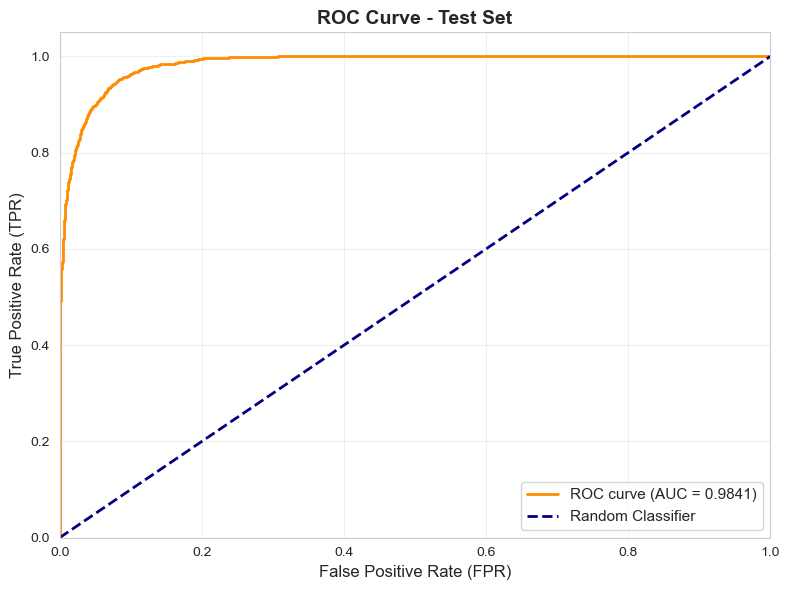

Saved: c:\Users\ngthtnhung\Documents\code tự học\TechSpire\skilio_mall_churn_prediction\outputs/roc_curve_test.png


In [84]:
# 2. ROC Curve for final model on test set
print("Creating ROC curve...")
fpr, tpr, _ = roc_curve(y_test.values, y_test_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.title('ROC Curve - Test Set', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUTS_DIR, 'roc_curve_test.png'), dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved: {os.path.join(OUTPUTS_DIR, 'roc_curve_test.png')}")

### 12.3 Precision-Recall Curve

Precision-Recall curve is particularly useful for imbalanced datasets, showing the trade-off between precision and recall at different thresholds.

Creating PR curve...


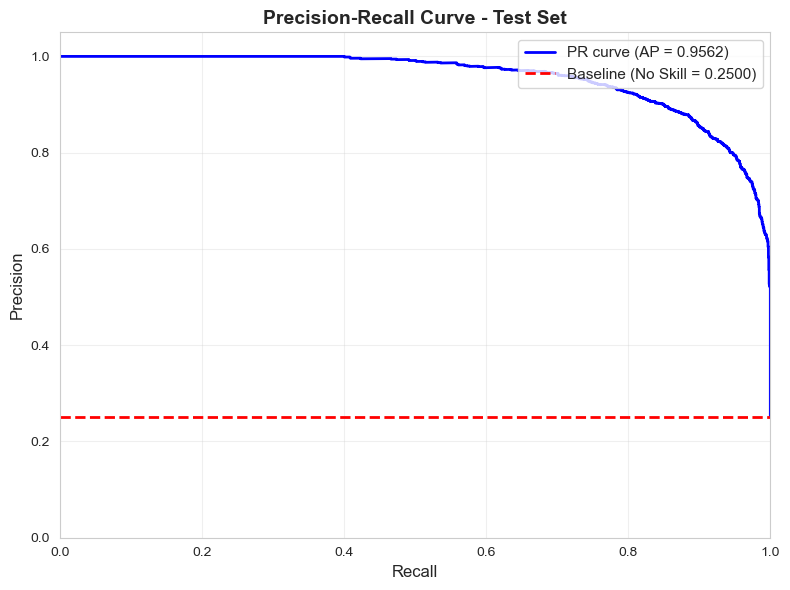

Saved: c:\Users\ngthtnhung\Documents\code tự học\TechSpire\skilio_mall_churn_prediction\outputs/precision_recall_curve_test.png


In [85]:
# 3. Precision-Recall Curve
print("Creating PR curve...")
precision_vals, recall_vals, pr_thresholds = precision_recall_curve(y_test.values, y_test_proba)

plt.figure(figsize=(8, 6))
plt.plot(recall_vals, precision_vals, color='blue', lw=2, label=f'PR curve (AP = {pr_test:.4f})')
plt.axhline(y=y_test.mean(), color='red', linestyle='--', lw=2, label=f'Baseline (No Skill = {y_test.mean():.4f})')
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve - Test Set', fontsize=14, fontweight='bold')
plt.legend(loc="upper right", fontsize=11)
plt.grid(alpha=0.3)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.tight_layout()
plt.savefig(os.path.join(OUTPUTS_DIR, 'precision_recall_curve_test.png'), dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved: {os.path.join(OUTPUTS_DIR, 'precision_recall_curve_test.png')}")

### 12.4 Confusion Matrix

Visual representation of model predictions versus actual labels, showing true positives, true negatives, false positives, and false negatives.

Creating confusion matrix heatmap...


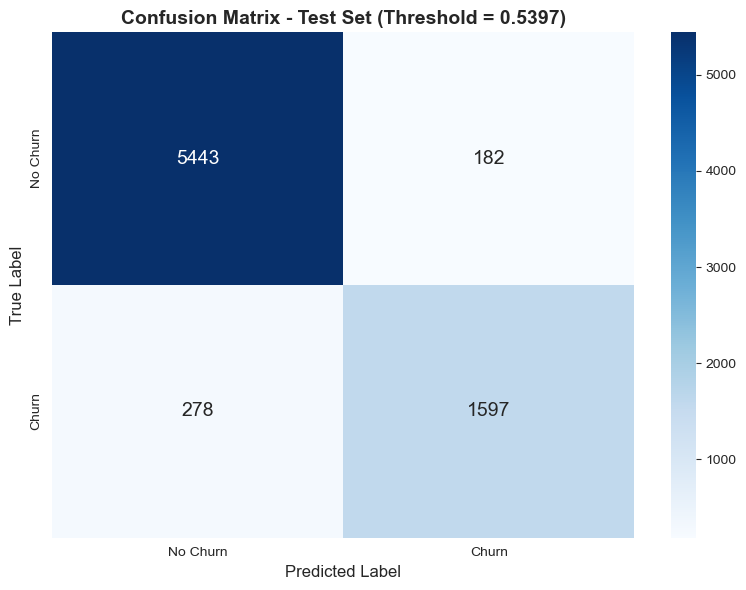

Saved: c:\Users\ngthtnhung\Documents\code tự học\TechSpire\skilio_mall_churn_prediction\outputs/confusion_matrix_test.png


In [86]:
# 4. Confusion Matrix Heatmap
print("Creating confusion matrix heatmap...")
cm = test_metrics['confusion_matrix']

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, 
            xticklabels=['No Churn', 'Churn'], 
            yticklabels=['No Churn', 'Churn'],
            annot_kws={"size": 14})
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title(f'Confusion Matrix - Test Set (Threshold = {best_threshold:.4f})', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUTS_DIR, 'confusion_matrix_test.png'), dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved: {os.path.join(OUTPUTS_DIR, 'confusion_matrix_test.png')}")

### 12.5 Performance Metrics Summary

Bar chart summarizing all key performance metrics on the test set for quick comparison.

Creating test metrics summary chart...


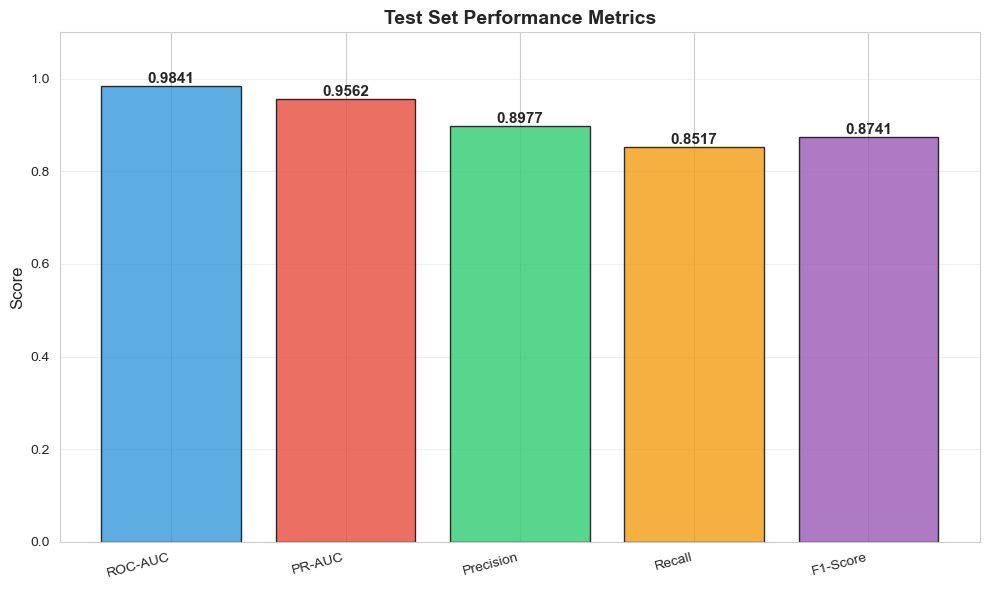

Saved: c:\Users\ngthtnhung\Documents\code tự học\TechSpire\skilio_mall_churn_prediction\outputs/test_metrics_summary.png


In [87]:
# 5. Test Set Metrics Summary Bar Chart
print("Creating test metrics summary chart...")
metrics_dict = {
    'ROC-AUC': roc_test,
    'PR-AUC': pr_test,
    'Precision': test_metrics['precision'],
    'Recall': test_metrics['recall'],
    'F1-Score': test_metrics['f1']
}

plt.figure(figsize=(10, 6))
colors_metrics = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6']
bars = plt.bar(metrics_dict.keys(), metrics_dict.values(), color=colors_metrics, alpha=0.8, edgecolor='black')
plt.ylim(0, 1.1)
plt.ylabel('Score', fontsize=12)
plt.title('Test Set Performance Metrics', fontsize=14, fontweight='bold')
plt.xticks(rotation=15, ha='right')
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUTS_DIR, 'test_metrics_summary.png'), dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved: {os.path.join(OUTPUTS_DIR, 'test_metrics_summary.png')}")

### 12.6 Cumulative Lift Chart

Lift chart demonstrates how much better the model performs compared to random selection when targeting top-scored customers. This is particularly useful for campaign optimization.

Creating lift chart...


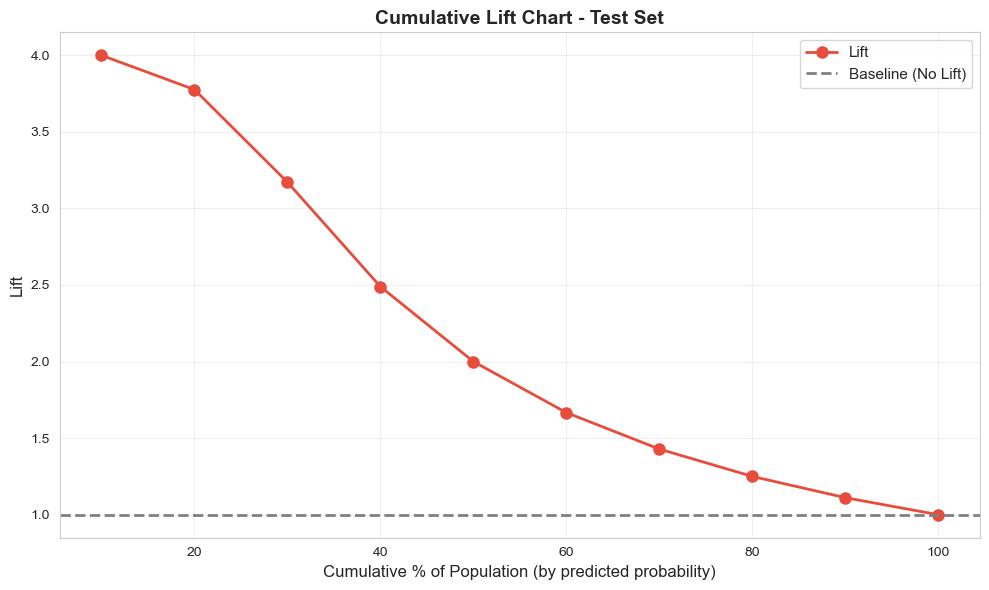

Saved: c:\Users\ngthtnhung\Documents\code tự học\TechSpire\skilio_mall_churn_prediction\outputs/lift_chart_test.png


In [88]:
# 6. Lift Chart
print("Creating lift chart...")
# Sort by predicted probability descending
df_lift = pd.DataFrame({
    'y_true': y_test.values,
    'y_proba': y_test_proba
}).sort_values('y_proba', ascending=False).reset_index(drop=True)

# Calculate cumulative statistics
n_samples = len(df_lift)
deciles = 10
samples_per_decile = n_samples // deciles

lift_data = []
for i in range(1, deciles + 1):
    top_n = samples_per_decile * i
    top_samples = df_lift.iloc[:top_n]
    
    # Cumulative metrics
    cum_actual_positive = top_samples['y_true'].sum()
    cum_predicted_positive = top_n
    baseline_positive = (df_lift['y_true'].sum() / n_samples) * top_n
    
    lift = cum_actual_positive / baseline_positive if baseline_positive > 0 else 0
    
    lift_data.append({
        'Decile': i,
        'Cumulative %': (top_n / n_samples) * 100,
        'Lift': lift
    })

df_lift_plot = pd.DataFrame(lift_data)

plt.figure(figsize=(10, 6))
plt.plot(df_lift_plot['Cumulative %'], df_lift_plot['Lift'], 
         marker='o', linewidth=2, markersize=8, color='#e74c3c', label='Lift')
plt.axhline(y=1, color='gray', linestyle='--', linewidth=2, label='Baseline (No Lift)')
plt.xlabel('Cumulative % of Population (by predicted probability)', fontsize=12)
plt.ylabel('Lift', fontsize=12)
plt.title('Cumulative Lift Chart - Test Set', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.legend(fontsize=11)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUTS_DIR, 'lift_chart_test.png'), dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved: {os.path.join(OUTPUTS_DIR, 'lift_chart_test.png')}")

### 12.7 Probability Distribution Analysis

Analyze how predicted probabilities are distributed for churned and non-churned customers. Good separation indicates strong model discrimination ability.

Creating probability distribution plot...


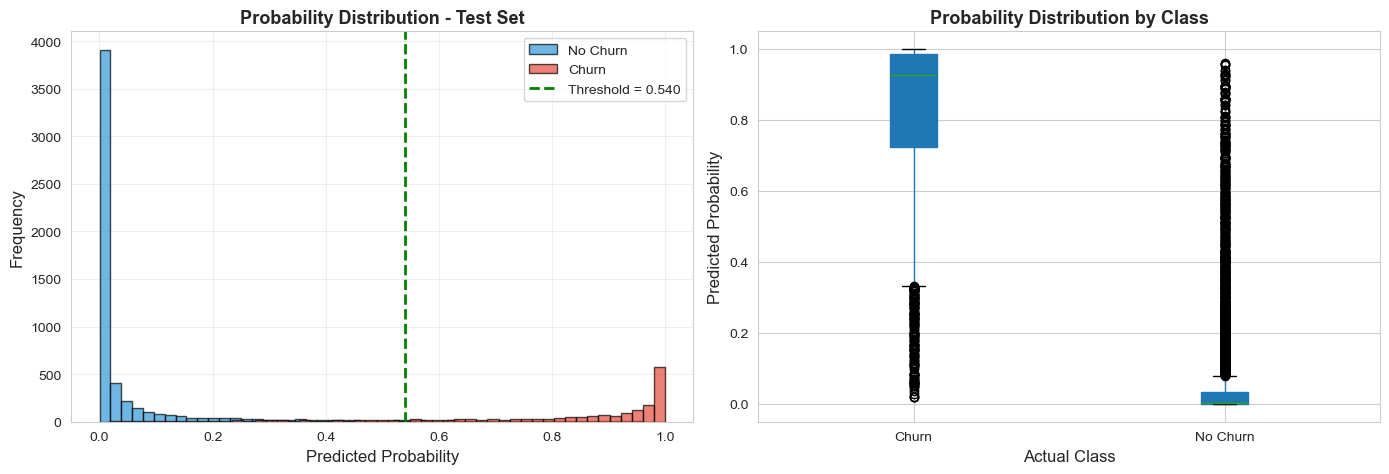

Saved: c:\Users\ngthtnhung\Documents\code tự học\TechSpire\skilio_mall_churn_prediction\outputs/probability_distribution_test.png


In [89]:
# 7. Probability Distribution by Class
print("Creating probability distribution plot...")
df_prob = pd.DataFrame({
    'Probability': y_test_proba,
    'Actual Class': ['Churn' if y == 1 else 'No Churn' for y in y_test.values]
})

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(df_prob[df_prob['Actual Class'] == 'No Churn']['Probability'], 
             bins=50, alpha=0.7, label='No Churn', color='#3498db', edgecolor='black')
axes[0].hist(df_prob[df_prob['Actual Class'] == 'Churn']['Probability'], 
             bins=50, alpha=0.7, label='Churn', color='#e74c3c', edgecolor='black')
axes[0].axvline(x=best_threshold, color='green', linestyle='--', linewidth=2, label=f'Threshold = {best_threshold:.3f}')
axes[0].set_xlabel('Predicted Probability', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Probability Distribution - Test Set', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(alpha=0.3)

# Box plot
df_prob.boxplot(column='Probability', by='Actual Class', ax=axes[1], patch_artist=True)
axes[1].set_xlabel('Actual Class', fontsize=12)
axes[1].set_ylabel('Predicted Probability', fontsize=12)
axes[1].set_title('Probability Distribution by Class', fontsize=13, fontweight='bold')
axes[1].get_figure().suptitle('')  # Remove automatic title
plt.tight_layout()
plt.savefig(os.path.join(OUTPUTS_DIR, 'probability_distribution_test.png'), dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved: {os.path.join(OUTPUTS_DIR, 'probability_distribution_test.png')}")

In [90]:
print("\nVISUALIZATION SUMMARY")
print(f"Created and saved 7 visualizations to directory: {OUTPUTS_DIR}")
print("\nList of files:")
print("  1. baseline_models_comparison.png - ROC-AUC & PR-AUC comparison")
print("  2. roc_curve_test.png - ROC Curve")
print("  3. precision_recall_curve_test.png - PR Curve")
print("  4. confusion_matrix_test.png - Confusion Matrix")
print("  5. test_metrics_summary.png - Metrics summary")
print("  6. lift_chart_test.png - Lift Chart")
print("  7. probability_distribution_test.png - Probability distribution")


VISUALIZATION SUMMARY
Created and saved 7 visualizations to directory: c:\Users\ngthtnhung\Documents\code tự học\TechSpire\skilio_mall_churn_prediction\outputs/

List of files:
  1. baseline_models_comparison.png - ROC-AUC & PR-AUC comparison
  2. roc_curve_test.png - ROC Curve
  3. precision_recall_curve_test.png - PR Curve
  4. confusion_matrix_test.png - Confusion Matrix
  5. test_metrics_summary.png - Metrics summary
  6. lift_chart_test.png - Lift Chart
  7. probability_distribution_test.png - Probability distribution


## 13. Model Interpretability with SHAP

Use SHAP (SHapley Additive exPlanations) to understand feature importance and how features contribute to model predictions. This provides transparency and helps build trust in the model.

Running SHAP summary plot (may be slow)...


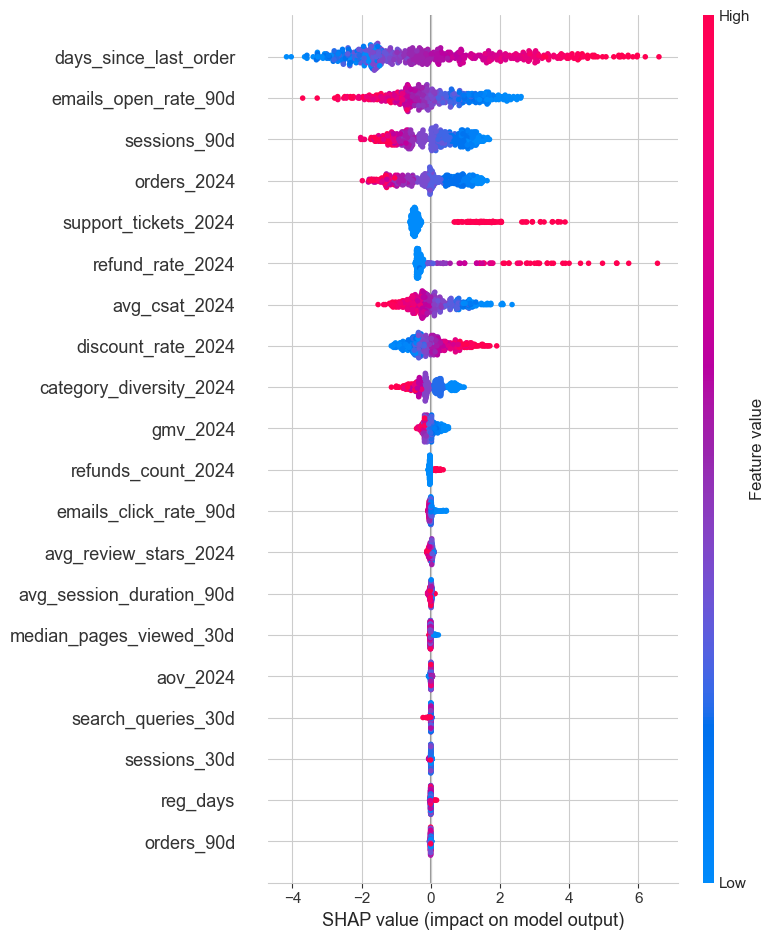

Saved SHAP summary plot.


In [91]:
print("Running SHAP summary plot (may be slow)...")
try:
    explainer = shap.TreeExplainer(final_model)
    # Use validation set for SHAP (smaller, representative sample)
    shap_sample = X_val_prep_df.sample(min(500, len(X_val_prep_df)), random_state=RANDOM_STATE)
    shap_values = explainer.shap_values(shap_sample.values)
    
    # Handle different SHAP output formats for binary classification
    # LightGBM/XGBoost may return shape (n_samples, n_features) or (2, n_samples, n_features)
    if isinstance(shap_values, list):
        # If list, take positive class (index 1)
        shap_values_plot = shap_values[1]
    elif len(shap_values.shape) == 3:
        # If 3D array, take positive class (index 1)
        shap_values_plot = shap_values[1]
    else:
        # If 2D array, use as-is
        shap_values_plot = shap_values
    
    # Create SHAP summary plot
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values_plot, shap_sample, show=False)
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUTS_DIR, 'shap_summary.png'), dpi=150, bbox_inches='tight')
    plt.show()
    print("Saved SHAP summary plot.")
except Exception as e:
    print("SHAP summary failed or not supported for this model:", e)
    import traceback
    traceback.print_exc()


## 14. Save Model Artifacts

Save the trained model, preprocessor, and feature names for production deployment. These artifacts can be loaded later for making predictions on new data.

In [92]:
model_path = os.path.join(OUTPUTS_DIR, 'final_model.pkl')
preproc_path = os.path.join(OUTPUTS_DIR, 'preprocessor.pkl')
joblib.dump(final_model, model_path)
joblib.dump(preprocessor, preproc_path)
print("Saved final model to:", model_path)
print("Saved preprocessor to:", preproc_path)

# Save selected features list
with open(os.path.join(OUTPUTS_DIR, 'selected_features.txt'), 'w') as f:
    for fn in feature_names:
        f.write(fn + "\n")
print("Saved selected feature names.")

Saved final model to: c:\Users\ngthtnhung\Documents\code tự học\TechSpire\skilio_mall_churn_prediction\outputs/final_model.pkl
Saved preprocessor to: c:\Users\ngthtnhung\Documents\code tự học\TechSpire\skilio_mall_churn_prediction\outputs/preprocessor.pkl
Saved selected feature names.


## 15. Final Report Summary

Consolidated summary of all key results including model performance metrics, optimal threshold, and artifact locations.

In [93]:
print("FINAL REPORT")
print("Model path:", model_path)
print("ROC-AUC (test):", roc_test)
print("PR-AUC (test):", pr_test)
print("Threshold:", best_threshold)
print("Precision/Recall/F1 (test):", test_metrics['precision'], test_metrics['recall'], test_metrics['f1'])
print("Lift@Top20%:", lift_results)
print("Artifacts saved to:", OUTPUTS_DIR)


FINAL REPORT
Model path: c:\Users\ngthtnhung\Documents\code tự học\TechSpire\skilio_mall_churn_prediction\outputs/final_model.pkl
ROC-AUC (test): 0.9841143466666669
PR-AUC (test): 0.9561987675286129
Threshold: 0.5396700776297952
Precision/Recall/F1 (test): 0.8976953344575604 0.8517333333333333 0.8741105637657361
Lift@Top20%: {'recall_at_k': 0.7552, 'lift_at_k': 3.776}
Artifacts saved to: c:\Users\ngthtnhung\Documents\code tự học\TechSpire\skilio_mall_churn_prediction\outputs/
